In [11]:
import os

import requests
import json

import pandas as pd
import numpy as np

from datetime import datetime
from datetime import timedelta

import webbrowser

import matplotlib.pyplot as plt
import seaborn as sns

from osrs_GE import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [45]:
df = read_CTI_master_file('24h')
df.head()

timestamp  avgHighPrice  avgLowPrice  highPriceVolume  \
id date                                                                 
2  2023-09-04  1693785600           158      153.000         25448193   
   2023-09-05  1693872000           157      152.000         20442989   
   2023-09-06  1693958400           155      151.000         18166461   
   2023-09-07  1694044800           154      151.000         19839631   
   2023-09-08  1694131200           153      150.000         19325295   

               lowPriceVolume  
id date                        
2  2023-09-04         7792403  
   2023-09-05         7067147  
   2023-09-06         7738376  
   2023-09-07         6687883  
   2023-09-08         7420479

# Cleaning

In [197]:
check(df)[0]

timestamp  avgHighPrice  avgLowPrice  highPriceVolume  \
id   date                                                                 
1779 2024-04-14  1713052800             1          NaN          4782387   
7936 2024-04-03  1712102400             1          NaN         92224230   
     2024-05-04  1714780800             1          NaN        156057008   
     2024-07-14  1720915200             1          NaN         96610687   

                 lowPriceVolume  
id   date                        
1779 2024-04-14               0  
7936 2024-04-03               0  
     2024-05-04               0  
     2024-07-14               0

In [177]:
for idx,new_df in df[df['lowPriceVolume']==0].groupby(level=0):
    print(idx, item_name_from_id(idx))

1779 Flax
7936 Pure essence


- pure essence can just set the price to 1 or just exclude because that never moves, same with the flax
- cowhide/rune armor set - can impute with a interpolated value from surrounding days or look at average price difference between high and low for the year

In [9]:
df.loc[(7936,'2024-04-03'),'avgLowPrice'] = 1
df.loc[(7936,'2024-05-04'),'avgLowPrice'] = 1
df.loc[(7936,'2024-07-14'),'avgLowPrice'] = 1
df.loc[(1779,'2024-04-14'),'avgLowPrice'] = 1

# Exploration yadda yadda

In [10]:
df.groupby("id")[['avgHighPrice','avgLowPrice','highPriceVolume','lowPriceVolume']].mean()

,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume
id,,,,
2,187.458,182.784,21634135.490,8220884.570
225,478.175,470.718,348161.107,581663.784
231,376.825,371.515,891819.715,835342.233
263,3606.751,3583.860,36722.370,106274.781
377,96.534,95.074,556995.370,810137.578
385,805.416,797.318,2718141.677,1625547.814
444,175.934,174.255,5433336.488,8655934.553
453,166.447,164.027,10187569.521,15550619.559
536,3218.956,3186.830,1117923.559,1285434.197


In [11]:
df[df['avgHighPrice'] < df['avgLowPrice']].shape

(441, 5)

- this occurs when volume buys and/or sells aggressively past the last trade price
- flipping opportunity?
- could also represent some large intraday volatility

---

In [14]:
df['avgWPrice'] = (df['avgHighPrice']*df['highPriceVolume'] + df['avgLowPrice']*df['lowPriceVolume'])/(df['highPriceVolume'] + df['lowPriceVolume'])
df['ttlVol'] = df['highPriceVolume'] + df['lowPriceVolume']
df['ttlNotional'] = df['avgWPrice']*df['ttlVol']

In [15]:
df.groupby("id")[['avgWPrice','ttlVol','ttlNotional']].mean().sort_values(by='ttlNotional',ascending=False)

,avgWPrice,ttlVol,ttlNotional
id,,,
4151,1625457.671,4787.868,7786741772.775
560,155.803,49851493.710,7777245970.789
536,3201.675,2403357.756,7645944441.992
2,186.165,29855020.060,5610172694.685
1513,1022.803,4160473.833,4255317672.562
453,164.958,25738189.079,4215961902.268
561,112.974,33941489.625,3753251888.745
385,802.329,4343689.490,3358731203.433
3000,7459.802,358345.929,2685718100.795


In [16]:
df.index.unique(level='id').shape

(25,)

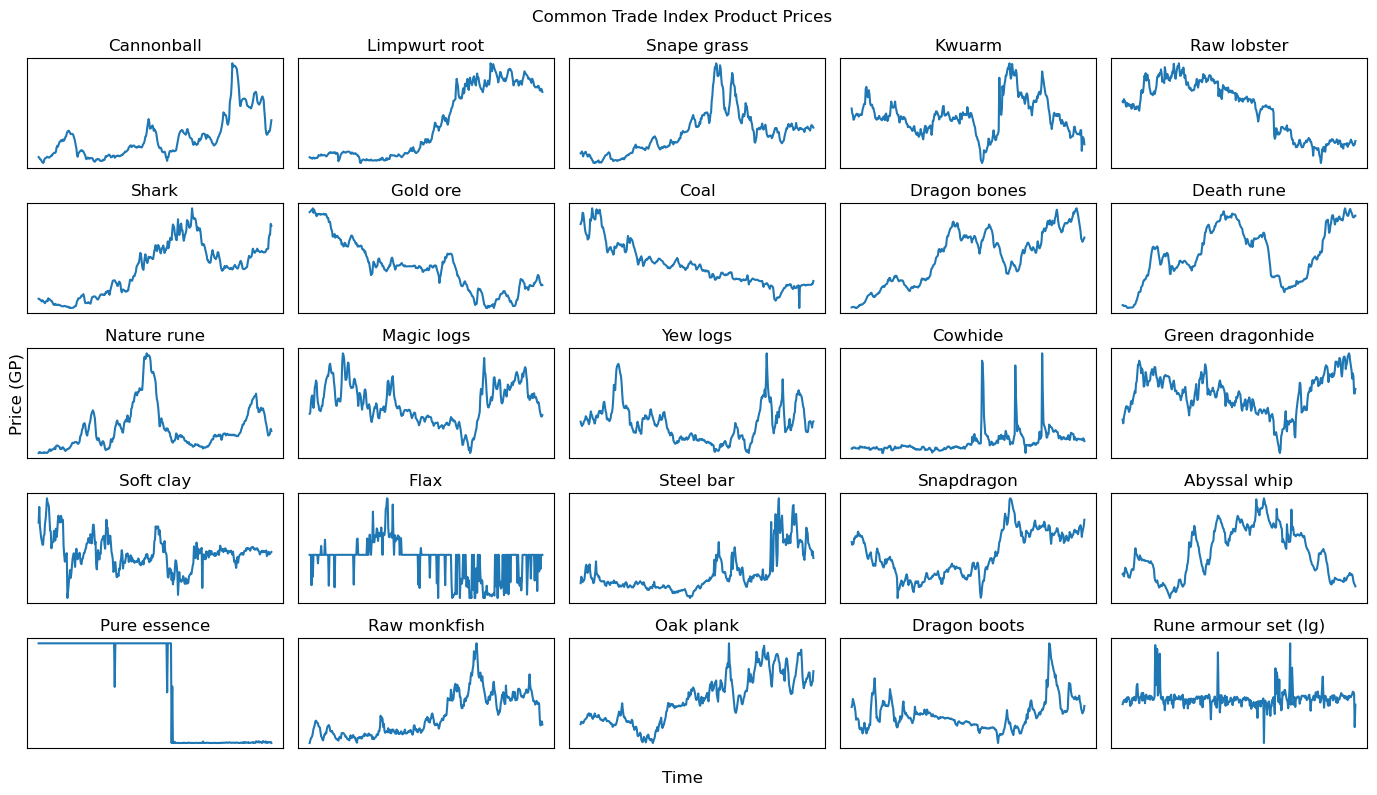

In [17]:
fig,axs = plt.subplots(5,5,figsize=(14,8))

ct = 0
for id, new_df in df.groupby(by='id'):
    ax = axs[ct//5, ct%5]
    ax.tick_params(bottom=False)
    
    ax.plot(new_df.index.get_level_values(1),new_df['avgWPrice'])
    ax.set_title(item_name_from_id(id))

    ct += 1


fig.supxlabel("Time")
fig.supylabel("Price (GP)")
fig.suptitle("Common Trade Index Product Prices")


plt.setp(axs, xticks=[], yticks=[])
fig.tight_layout()
plt.show()

In [18]:
((np.log(df.groupby('id')['avgWPrice'].shift(-1)/df['avgWPrice'])).groupby('id').std()*np.sqrt(364)).sort_values()

id
444     0.112
3000    0.189
1513    0.263
377     0.276
13024   0.279
536     0.296
1753    0.319
4151    0.329
11840   0.348
2       0.350
8778    0.352
560     0.361
561     0.428
1761    0.478
263     0.523
1515    0.546
453     0.556
385     0.567
225     0.584
231     0.679
2353    0.694
7944    0.782
7936    1.082
1739    2.181
1779    4.195
Name: avgWPrice, dtype: float64

---

In [20]:
df['logRet'] = np.log(df['avgWPrice']/df.groupby('id')['avgWPrice'].shift(1))

df['simpRet'] = (df['avgWPrice']/df.groupby('id')['avgWPrice'].shift(1)) - 1

df.loc[4151].head()

,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,avgWPrice,ttlVol,ttlNotional,logRet,simpRet
date,,,,,,,,,,
2023-09-04,1693785600,1470672,1456465.000,2054,2370,1463061.107,4424,6472582338.000,NaN,NaN
2023-09-05,1693872000,1472692,1463019.000,1883,2089,1467604.664,3972,5829325727.000,0.003,0.003
2023-09-06,1693958400,1454188,1436174.000,1931,1823,1445440.125,3754,5426182230.000,-0.015,-0.015
2023-09-07,1694044800,1476230,1462323.000,1920,1897,1469318.400,3817,5608388331.000,0.016,0.017
2023-09-08,1694131200,1518417,1503441.000,1841,2260,1510163.950,4101,6193182357.000,0.027,0.028


In [21]:
# return in % over the time frame
(df.groupby('id')['avgWPrice'].agg(TotalReturn=lambda x:(x.iloc[-1]/x.iloc[0]) - 1)*100).sort_values(by='TotalReturn')

,TotalReturn
id,
7936,-49.955
453,-38.862
263,-19.108
444,-18.140
377,-15.874
1761,-9.560
4151,-6.278
1513,-0.426
13024,-0.079


---

---

In [25]:
dt_idx = int(df.index.get_level_values(1).unique().shape[0]*.7)
dt_split = df.index.get_level_values(1).unique()[dt_idx]
df.index.get_level_values(1) < dt_split

array([ True,  True,  True, ..., False, False, False])

In [26]:
tr_idx = int(df.index.get_level_values(1).unique().shape[0]*.67)

dt_split = df.index.get_level_values(1).unique()[tr_idx]

df_train = df[df.index.get_level_values(1) < dt_split]
df_test = df[df.index.get_level_values(1) >= dt_split]

print(df_train.shape)
print(df_test.shape)

(6100, 10)
(3025, 10)


In [27]:
df_train

timestamp  avgHighPrice  avgLowPrice  highPriceVolume  \
id    date                                                                 
2     2023-09-04  1693785600           158      153.000         25448193   
      2023-09-05  1693872000           157      152.000         20442989   
      2023-09-06  1693958400           155      151.000         18166461   
      2023-09-07  1694044800           154      151.000         19839631   
      2023-09-08  1694131200           153      150.000         19325295   
...                      ...           ...          ...              ...   
13024 2024-04-30  1714435200        135965   134979.000              413   
      2024-05-01  1714521600        131619   128205.000              451   
      2024-05-02  1714608000        136943   131533.000              388   
      2024-05-03  1714694400        136759   129910.000              283   
      2024-05-04  1714780800        130480   128073.000              527   

                  lowPriceVolume  avgWPrice    ttlVol    ttlNotional  logRet  \
id    date                                                                     
2     2023-09-04         7792403    156.828  33240596 5213052153.000     NaN   
      2023-09-05         7067147    155.716  27510136 4283755617.000  -0.007   
      2023-09-06         7738376    153.805  25904837 3984296231.000  -0.012   
      2023-09-07         6687883    153.244  26527514 4065173507.000  -0.004   
      2023-09-08         7420479    152.168  26745774 4069841985.000  -0.007   
...                          ...        ...       ...            ...     ...   
13024 2024-04-30             216 135626.405       629   85309009.000   0.065   
      2024-05-01             125 130878.115       576   75385794.000  -0.036   
      2024-05-02             235 134902.310       623   84044139.000   0.030   
      2024-05-03             179 134105.383       462   61956687.000  -0.006   
      2024-05-04             174 129882.542       701   91047662.000  -0.032   

                  simpRet  
id    date                 
2     2023-09-04      NaN  
      2023-09-05   -0.007  
      2023-09-06   -0.012  
      2023-09-07   -0.004  
      2023-09-08   -0.007  
...                   ...  
13024 2024-04-30    0.067  
      2024-05-01   -0.035  
      2024-05-02    0.031  
      2024-05-03   -0.006  
      2024-05-04   -0.031  

[6100 rows x 10 columns]

In [28]:
df_corr = pd.DataFrame()

for idx,df_select in df_train.groupby(level='id'):
    date_index = df_select.index.get_level_values(1)
    
    temp = pd.DataFrame(index = date_index)
    temp[idx] = df_select.loc[idx,'simpRet']

    df_corr = df_corr.join(temp,how='outer')

df_corr = df_corr.dropna()

In [29]:
df_train.groupby(by='id')['avgHighPrice'].agg(nrow = lambda x:x.shape[0])

,nrow
id,
2,244
225,244
231,244
263,244
377,244
385,244
444,244
453,244
536,244


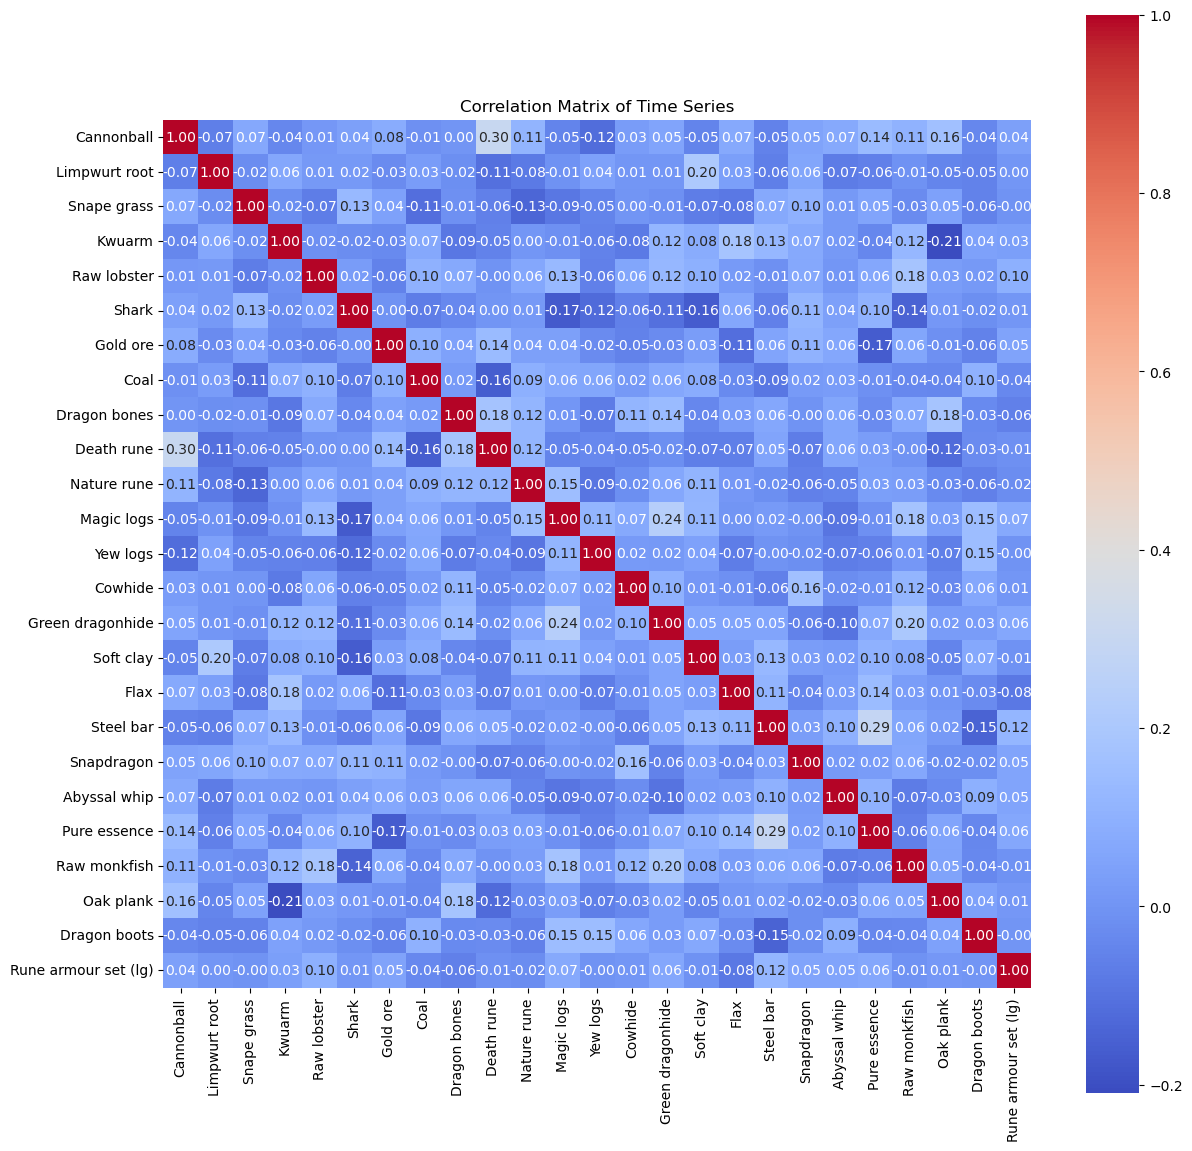

In [31]:
corr_matrix = df_corr.corr()
plt.figure(figsize=(14,14))

sns.heatmap(corr_matrix,annot=True,fmt=".2f",cmap='coolwarm',square=True,yticklabels = 
            pd.Series(df_train.index.get_level_values(0).unique()).apply(item_name_from_id),
           xticklabels=
           pd.Series(df_train.index.get_level_values(0).unique()).apply(item_name_from_id))

#sns.heatmap(corr_matrix,annot=True,fmt=".2f",cmap='coolwarm',square=True)
plt.title('Correlation Matrix of Time Series')
plt.show()

In [202]:
from statsmodels.tsa.stattools import adfuller

pd.reset_option('display.float_format')
(df_train.dropna()).groupby(level=['id'])['simpRet'].agg(ADFtest = 
                                                                lambda x:adfuller(x)[1]<.05,
                                                               ADFtest_p_val =
                                                                lambda x:adfuller(x)[1])

,ADFtest,ADFtest_p_val
id,,
2,True,1.245243e-14
225,True,1.744264e-24
231,True,5.222936e-08
263,True,3.300538e-07
377,True,4.016349e-29
385,True,1.283312e-18
444,True,1.913534e-05
453,True,1.868880e-05
536,True,4.747214e-16


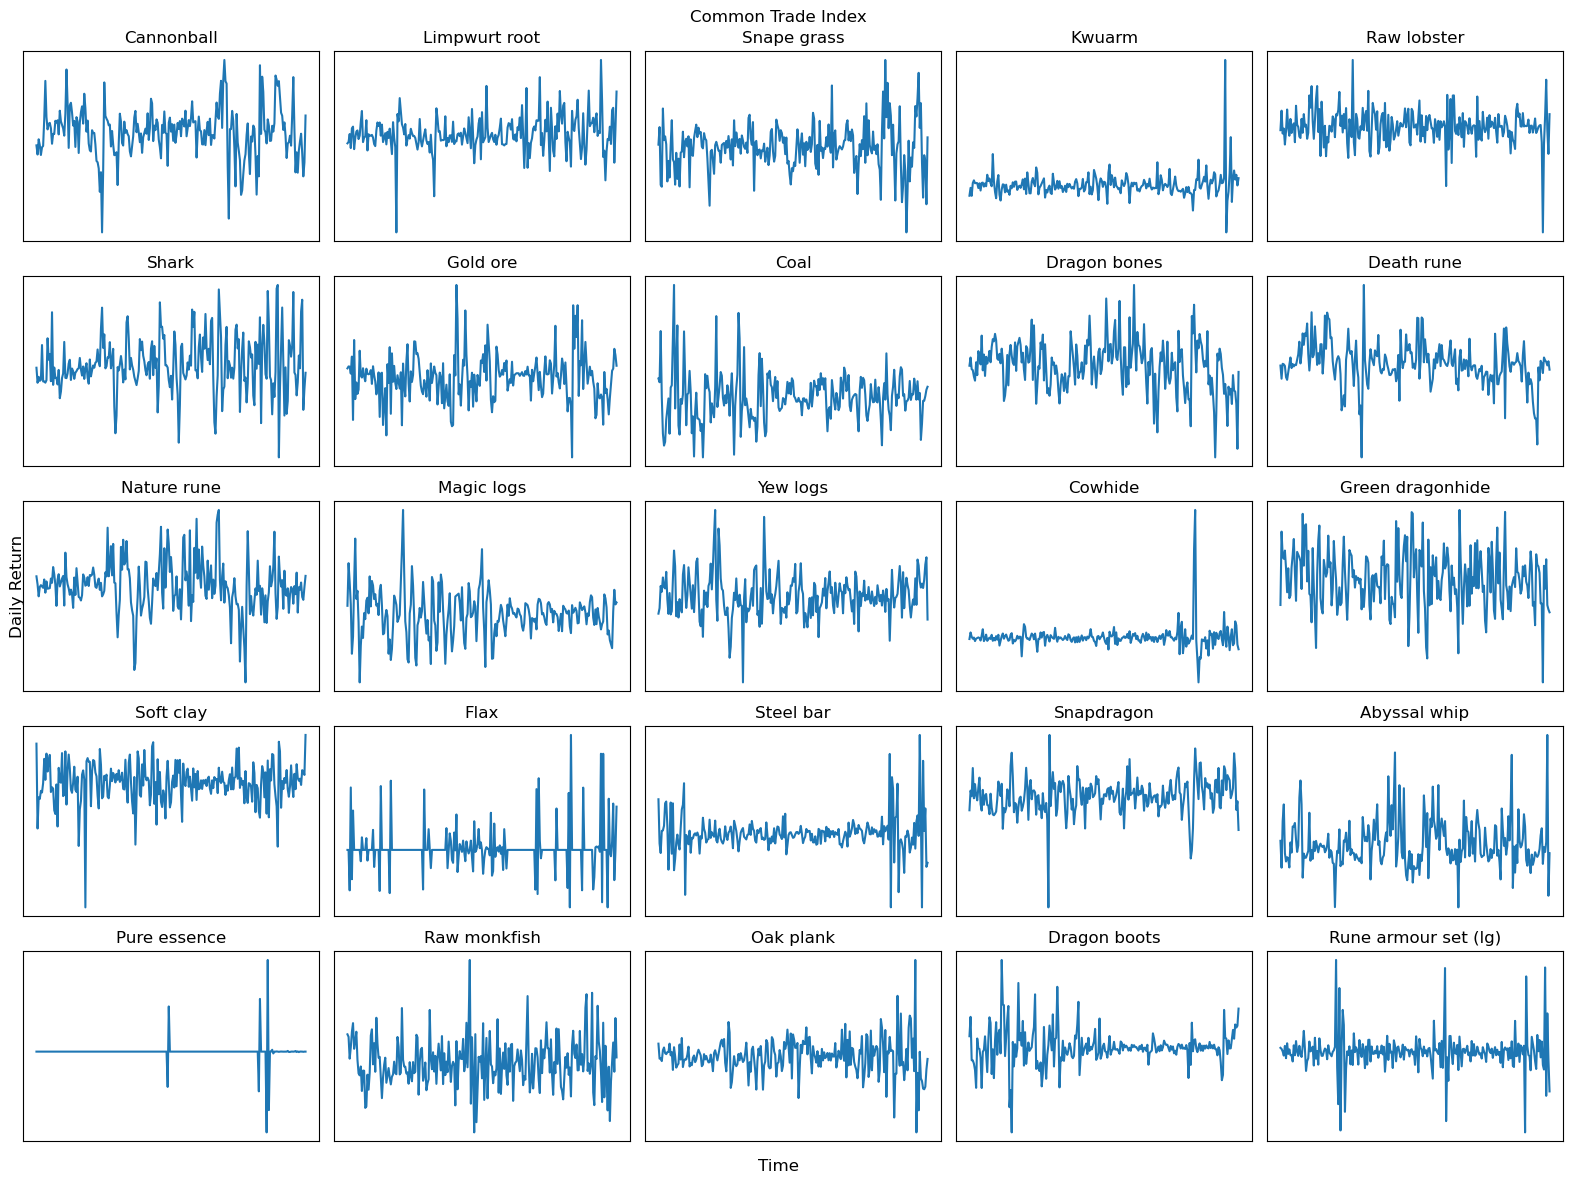

In [34]:
fig,axs = plt.subplots(5,5,figsize=(16,12))

ct = 0
for id, new_df in df_train.groupby(level='id'):
    ax = axs[ct//5, ct%5]
    ax.tick_params(bottom=False)
    
    ax.plot(new_df.index.get_level_values(1),new_df['simpRet'])
    ax.set_title(item_name_from_id(id))

    ct += 1

fig.supxlabel("Time")
fig.supylabel("Daily Return")
fig.suptitle("Common Trade Index")


plt.setp(axs, xticks=[], yticks=[])
fig.tight_layout()
plt.show()

---

# TS analysis on abyssal whip

In [37]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [38]:
df_whip_tr = df_train.dropna().loc[4151]
df_whip_tr.head()

,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,avgWPrice,ttlVol,ttlNotional,logRet,simpRet
date,,,,,,,,,,
2023-09-05,1693872000,1472692,1463019.0,1883,2089,1.467605e+06,3972,5.829326e+09,0.003101,0.003106
2023-09-06,1693958400,1454188,1436174.0,1931,1823,1.445440e+06,3754,5.426182e+09,-0.015218,-0.015103
2023-09-07,1694044800,1476230,1462323.0,1920,1897,1.469318e+06,3817,5.608388e+09,0.016385,0.016520
2023-09-08,1694131200,1518417,1503441.0,1841,2260,1.510164e+06,4101,6.193182e+09,0.027420,0.027799
2023-09-09,1694217600,1511792,1494355.0,2185,2647,1.502240e+06,4832,7.258823e+09,-0.005261,-0.005247


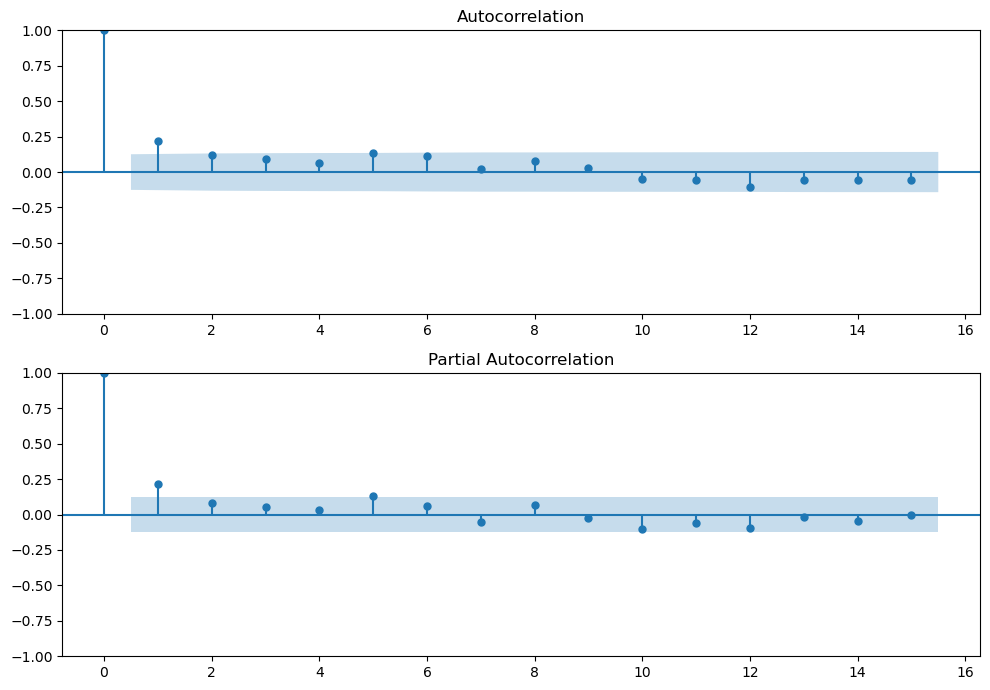

In [39]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))
plot_acf(df_whip_tr['simpRet'],lags=15, ax=ax[0])
plot_pacf(df_whip_tr['simpRet'],lags=15, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

In [40]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_whip_tr['simpRet'], order=(1,0,0))
model_fit = model.fit()

In [41]:
def ARIMA_CV_SCORE(series,order = (1,0,0),start_point = 10):
    errors = []
    conv_issues = []
    preds = []
    for k in range(start_point,series.shape[0]-1):
        model = ARIMA(series.iloc[:k],order=order)
        model_fit = model.fit(method_kwargs={'maxiter':100})
        pred = (model_fit.forecast()).values[0]
        
        errors.append(pred - series.iloc[k+1])
        preds.append(pred)
        #print(k)
    
    ret_df = pd.DataFrame(index = series.index[start_point:-1],data = {'Pred':preds,'Real':series.iloc[start_point:-1]})
    errors = np.array(errors)
    return {'mean_error':errors.mean(), 'errors':errors, 'abs_errors':abs(errors),'ret_df':ret_df}

In [42]:
avg_err, err, abs_err, tmp_df = ARIMA_CV_SCORE(df_whip_tr['simpRet'],(1,0,0))

C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

In [43]:
res_list = {}

for p in range(1,6):
    res_list[p] = ARIMA_CV_SCORE(df_whip_tr['simpRet'],(p,0,0))

C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

In [44]:
[res_list[x]['abs_errors'].mean() for x in res_list]

[0.011947565243785409,
 0.012036164118026847,
 0.012093954756319926,
 0.012172110505328002,
 0.012016740716936918]

In [45]:
[np.sqrt(np.sum(res_list[x]['errors']**2)) for x in res_list]

[0.2541140237195993,
 0.2538739765414487,
 0.2541084370911475,
 0.2558615460612295,
 0.25672146758193315]

In [206]:
model = ARIMA(df_whip_tr['simpRet'],order = (1,0,0))
model_fit = model.fit(method_kwargs={'maxiter':100})

In [208]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                simpRet   No. Observations:                  243
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 665.114
Date:                Thu, 05 Sep 2024   AIC                          -1324.228
Time:                        16:58:40   BIC                          -1313.749
Sample:                    09-05-2023   HQIC                         -1320.007
                         - 05-04-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.721      0.471      -0.002       0.004
ar.L1          0.2160      0.045      4.756      0.000       0.127       0.305
sigma2         0.0002   1.55e-05     15.841      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               140.88
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                             0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

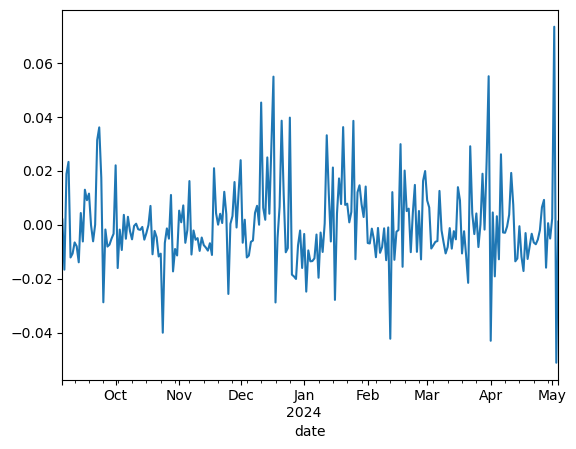

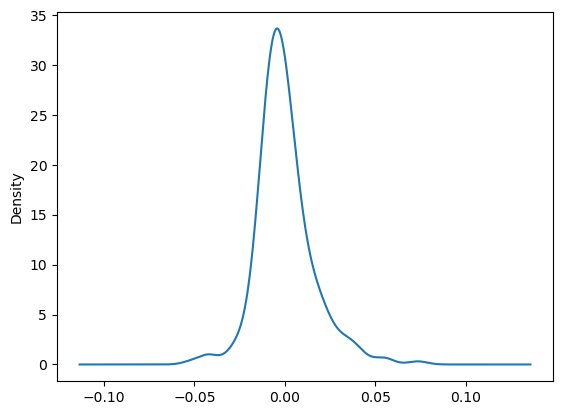

count   243.00000
mean     -0.00000
std       0.01570
min      -0.05121
25%      -0.00873
50%      -0.00203
75%       0.00636
max       0.07352
dtype: float64

In [214]:
#pd.reset_option('display.float_format')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

residuals = model_fit.resid
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

residuals.describe()

In [49]:
df_whip_te = df_test.dropna().loc[4151]
df_whip_te.head()

,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,avgWPrice,ttlVol,ttlNotional,logRet,simpRet
date,,,,,,,,,,
2024-05-05,1714867200,1875130,1856774.0,2903,2909,1.865943e+06,5812,1.084486e+10,-0.002736,-0.002733
2024-05-06,1714953600,1865004,1849538.0,2314,2312,1.857274e+06,4626,8.591751e+09,-0.004656,-0.004645
2024-05-07,1715040000,1862625,1844815.0,1947,2047,1.853497e+06,3994,7.402867e+09,-0.002036,-0.002034
2024-05-08,1715126400,1840624,1820968.0,2155,2112,1.830895e+06,4267,7.812429e+09,-0.012269,-0.012194
2024-05-09,1715212800,1820091,1797803.0,2219,2079,1.809310e+06,4298,7.776414e+09,-0.011859,-0.011789


In [113]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  363
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 957.590
Date:                Thu, 05 Sep 2024   AIC                          -1907.179
Time:                        14:11:53   BIC                          -1891.601
Sample:                             0   HQIC                         -1900.987
                                - 363                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.766e-06      0.001     -0.006      0.995      -0.003       0.003
ar.L1          0.0722      0.033      2.210      0.027       0.008       0.136
ar.L2          0.1116      0.069      1.612      0.107      -0.024       0.247
sigma2         0.0003    1.1e-05     27.099      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1873.12
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                             1.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

Test RMSE: 0.02082


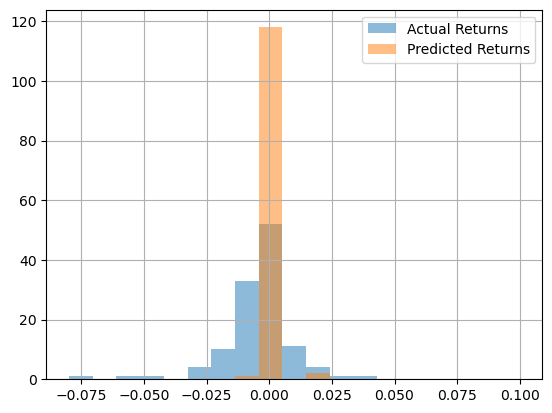

In [115]:
from sklearn.metrics import mean_squared_error
from math import sqrt

history = pd.DataFrame(df_train.loc[4151]['simpRet'].dropna())

predictions1 = []

AR_betas = pd.DataFrame()


for i in range(df_whip_te.shape[0]):
    model = ARIMA(history['simpRet'].values,order=(1,0,0))
    model_fit=model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions1.append(yhat)
    obs = df_whip_te['simpRet'].iloc[i]
    history.loc[df_whip_te.index[i],'simpRet'] = obs
    AR_betas.loc[df_whip_te.index[i],'AR1_beta'] = model_fit.params[1]

    #print('predicted=%f, expected=%f' % (yhat, obs))

rmse = sqrt(mean_squared_error(df_whip_te['simpRet'].values,predictions1))
print('Test RMSE: %.5f' % rmse)

bins = np.linspace(-.08,.10,20)
df_whip_te['simpRet'].hist(bins=bins,alpha=0.5,label='Actual Returns')
plt.hist(predictions1,bins,alpha=0.5,label='Predicted Returns')
plt.legend(loc='upper right')
plt.show()

In [51]:
(abs(np.array(predictions))>.01).sum()

3

C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

Test RMSE: 0.02066


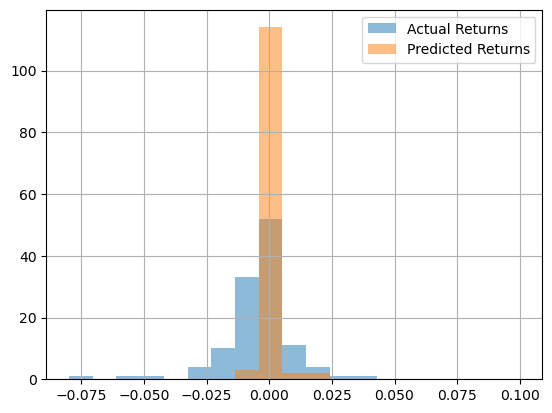

In [119]:
history = pd.DataFrame(df_train.loc[4151]['simpRet'].dropna())

predictions2 = []

for i in range(df_whip_te.shape[0]):
    model = ARIMA(history['simpRet'].values,order=(2,0,0))
    model_fit=model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions2.append(yhat)
    obs = df_whip_te['simpRet'].iloc[i]
    history.loc[df_whip_te.index[i],'simpRet'] = obs
    AR_betas.loc[df_whip_te.index[i],'AR2_beta1'] = model_fit.params[1]
    AR_betas.loc[df_whip_te.index[i],'AR2_beta2'] = model_fit.params[2]
    #print('predicted=%f, expected=%f' % (yhat, obs))

rmse = sqrt(mean_squared_error(df_whip_te['simpRet'].values,predictions2))
print('Test RMSE: %.5f' % rmse)

bins = np.linspace(-.08,.10,20)
df_whip_te['simpRet'].hist(bins=bins,alpha=0.5,label='Actual Returns')
plt.hist(predictions2,bins,alpha=0.5,label='Predicted Returns')
plt.legend(loc='upper right')
plt.show()

In [53]:
print((abs(np.array(df_whip_te['simpRet']))>.01).sum())
print((abs(np.array(predictions1))>.01).sum())
print((abs(np.array(predictions2))>.01).sum())

42
3
3


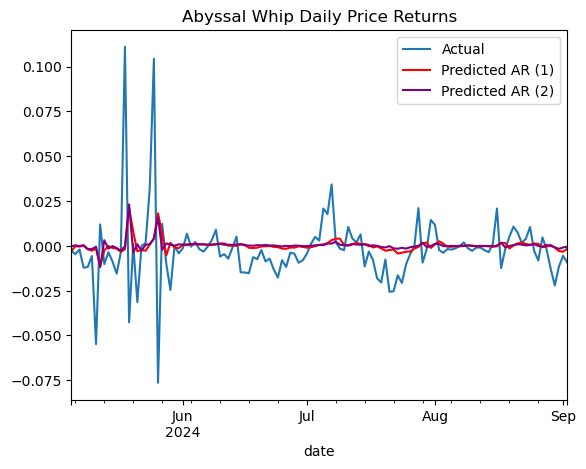

In [54]:
df_whip_te['simpRet'].plot(label='Actual')
plt.plot(df_whip_te.index,predictions2,color='red',label='Predicted AR (2)')
plt.plot(df_whip_te.index,predictions1,color='purple',label='Predicted AR (1)')
plt.legend()
plt.title("Abyssal Whip Daily Price Returns")
plt.show()

------

## AR model but optimizing on a different loss function

- In order to develop a reasonable investing strategy, we likely need a better loss function than just RMSE or MAE
- Sign matters more than just squared distance
    - what's worse than buying when you shouldn't have? buying when you should've sold (and vice versa)
- https://stackoverflow.com/questions/50711530/what-would-be-a-good-loss-function-to-penalize-the-magnitude-and-sign-difference

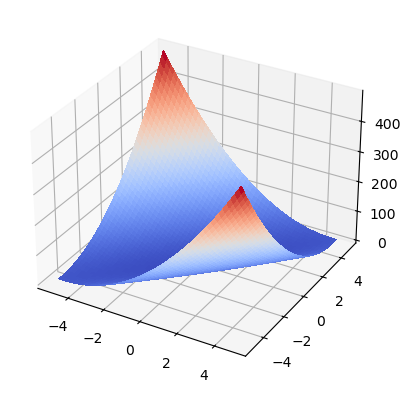

In [58]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def elliptic_paraboloid_loss(x, y, c_diff_sign=4, c_same_sign=0.1):
    # Compute a rotated elliptic parabaloid.
    t = np.pi / 4
    x_rot = (x * np.cos(t)) + (y * np.sin(t))
    y_rot = (x * -np.sin(t)) + (y * np.cos(t))
    z = ((x_rot**2) / c_diff_sign) + ((y_rot**2) / c_same_sign) 

    return(z)

def elliptic_paraboloid_loss_obj(B_vec, x_mat, y_obs,c_diff_sign = 8,c_same_sign = 0.001):
    # x_mat is nxp
    # B_mat is px1
    # y_obs is nx1
    n = x_mat.shape[0]
    p = x_mat.shape[1]

    B_vec = B_vec.reshape(p,1)
    y_obs = y_obs.reshape(n,1)

    return elliptic_paraboloid_loss(np.matmul(x_mat,B_vec),y_obs,c_diff_sign,c_same_sign).sum()

a = np.arange(-5, 5, 0.1)
b = np.arange(-5, 5, 0.1)

loss_map = np.zeros((len(a), len(b)))

for i, a_i in enumerate(a):
    for j, b_j in enumerate(b):
        loss_map[i, j] = elliptic_paraboloid_loss(a_i, b_j)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y = np.meshgrid(a, b)
surf = ax.plot_surface(X, Y, loss_map, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

In [59]:
def create_lagged_df(series,lags):
    res = pd.DataFrame(series)
    col_name = res.columns[0]
    for k in range(1,lags+1):
        res[col_name + str(k)] = res[col_name].shift(k)
    return res

### Experimenting with AR(1)

Training data shape (242, 1)
Observation data shape (242,)
Beta vector shape (1,)
Minimization Complete
Beta1 = 0.2199
Elliptic Paraboloid Loss 0.0012734737510502214


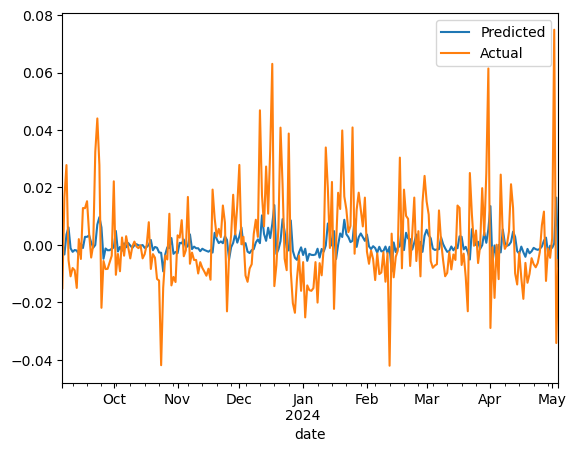

In [153]:
# Constructing the X matrix
X_tr = pd.DataFrame(df_whip_tr['simpRet'])

from scipy.optimize import minimize

# simpRet is our Y
# simpRet1 and simpRet 2 are our X

X_tr['simpRet1'] = X_tr['simpRet'].shift(1)

# get rid of the NaN's for experimenting purposes
X_tr = X_tr.dropna()

X_mat = X_tr[['simpRet1']].values
Y_vec = X_tr['simpRet'].values
B_init = np.ones(X_mat.shape[1])

print('Training data shape',X_mat.shape)
print('Observation data shape',Y_vec.shape)
print('Beta vector shape',B_init.shape)

res = minimize(elliptic_paraboloid_loss_obj,B_init,method='nelder-mead',args=(X_mat,Y_vec))

print("Minimization Complete")
print('Beta1 = %.4f' % (res.x[0]))

print('Elliptic Paraboloid Loss', elliptic_paraboloid_loss(np.matmul(X_mat,res.x),Y_vec).mean())

pd.DataFrame(data={'Predicted':np.matmul(X_mat,res.x),'Actual':Y_vec},index=X_tr.index).plot()
plt.show()

$$ \hat{R_t} = .2199 R_{t-1} $$

### Experimenting with AR(2)

Training data shape (241, 2)
Observation data shape (241,)
Beta vector shape (2,)
Minimization Complete
Beta1 = 0.2020, Beta2 = 0.0861
Elliptic Paraboloid Loss 0.0012651290587760416


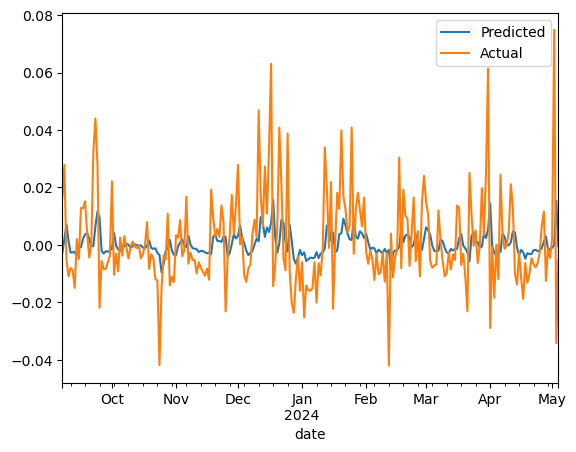

In [150]:
# Constructing the X matrix
X_tr = pd.DataFrame(df_whip_tr['simpRet'])

# simpRet is our Y
# simpRet1 and simpRet 2 are our X

X_tr['simpRet1'] = X_tr['simpRet'].shift(1)
X_tr['simpRet2'] = X_tr['simpRet'].shift(2)

# get rid of the NaN's for experimenting purposes
X_tr = X_tr.dropna()

X_mat = X_tr[['simpRet1','simpRet2']].values
Y_vec = X_tr['simpRet'].values
B_init = np.ones(X_mat.shape[1])

print('Training data shape', X_mat.shape)
print('Observation data shape', Y_vec.shape)
print('Beta vector shape', B_init.shape)

res = minimize(elliptic_paraboloid_loss_obj,B_init,method='nelder-mead',args=(X_mat,Y_vec))

print("Minimization Complete")
print('Beta1 = %.4f, Beta2 = %.4f' % (res.x[0], res.x[1]))

print('Elliptic Paraboloid Loss', elliptic_paraboloid_loss(np.matmul(X_mat,res.x),Y_vec).mean())

pd.DataFrame(data={'Predicted':np.matmul(X_mat,res.x),'Actual':Y_vec},index=X_tr.index).plot()
plt.show()

$$ \hat{R}_t = 0.2020*R_{t-1} + 0.0861 *R_{t-2} $$

### Experimenting with walk-forward

In [70]:
df_whip = df.loc[4151]

df_whip['simpRet'][dt_split+timedelta(days=1):]

date
2024-05-06   -0.005
2024-05-07   -0.002
2024-05-08   -0.012
2024-05-09   -0.012
2024-05-10   -0.006
              ...  
2024-08-29   -0.013
2024-08-30   -0.022
2024-08-31   -0.011
2024-09-01   -0.006
2024-09-02   -0.009
Freq: D, Name: simpRet, Length: 120, dtype: float64

In [133]:
pd.options.mode.chained_assignment = None  # default='warn'
predictions = pd.DataFrame(columns=['pred_AR1','pred_AR2','obs'])

X = df_whip[['simpRet']]
X_tr1 = create_lagged_df(X,1).dropna()
X_tr2 = create_lagged_df(X,2).dropna()

for date in df_whip_te.index:
    tr_date = date-timedelta(days=1)
    
    X_mat1 = X_tr1[:tr_date].drop(labels='simpRet',axis=1).values
    Y_vec1 = X_tr1['simpRet'][:tr_date].values
    
    X_mat2 = X_tr2[:tr_date].drop(labels='simpRet',axis=1).values
    Y_vec2 = X_tr2['simpRet'][:tr_date].values
    
    res1 = minimize(elliptic_paraboloid_loss_obj,[1]*1,method='nelder-mead',args=(X_mat1,Y_vec1))
    res2 = minimize(elliptic_paraboloid_loss_obj,[1]*2,method='nelder-mead',args=(X_mat2,Y_vec2))

    AR_betas.loc[date,'AR1e_beta'] = res1.x[0]
    AR_betas.loc[date,'AR2e_beta1'] = res2.x[0]
    AR_betas.loc[date,'AR2e_beta2'] = res2.x[1]
    
    x_vec_test1 = X_tr1.loc[date].drop('simpRet')
    x_vec_test2 = X_tr2.loc[date].drop('simpRet')
    y = X_tr1.loc[date]['simpRet']

    predictions.loc[date,'pred_AR1'] = np.matmul(res1.x,x_vec_test1)
    predictions.loc[date,'pred_AR2'] = np.matmul(res2.x,x_vec_test2)
    predictions.loc[date,'obs'] = y

In [135]:
AR_betas

,AR1_beta,AR2_beta1,AR2_beta2,AR1e_beta,AR2e_beta1,AR2e_beta2
2024-05-05,0.216,0.198,0.082,0.220,0.202,0.086
2024-05-06,0.216,0.199,0.082,0.220,0.202,0.085
2024-05-07,0.217,0.199,0.083,0.220,0.202,0.086
2024-05-08,0.217,0.199,0.083,0.220,0.202,0.086
2024-05-09,0.217,0.199,0.084,0.221,0.202,0.087
...,...,...,...,...,...,...
2024-08-29,0.076,0.068,0.111,0.076,0.068,0.111
2024-08-30,0.076,0.068,0.110,0.076,0.068,0.110
2024-08-31,0.078,0.070,0.110,0.078,0.070,0.110
2024-09-01,0.080,0.072,0.111,0.080,0.072,0.111


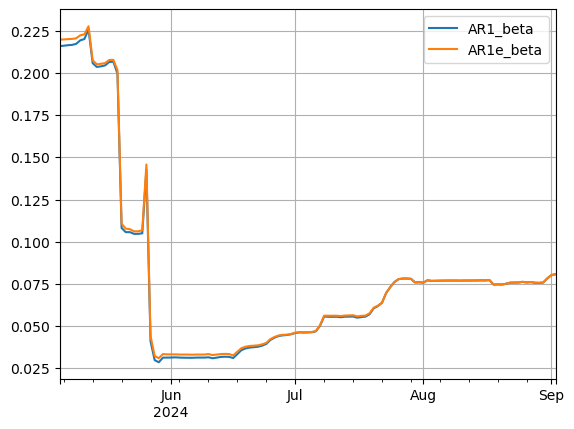

In [141]:
AR_betas[['AR1_beta','AR1e_beta']].plot()
plt.grid()
plt.show()

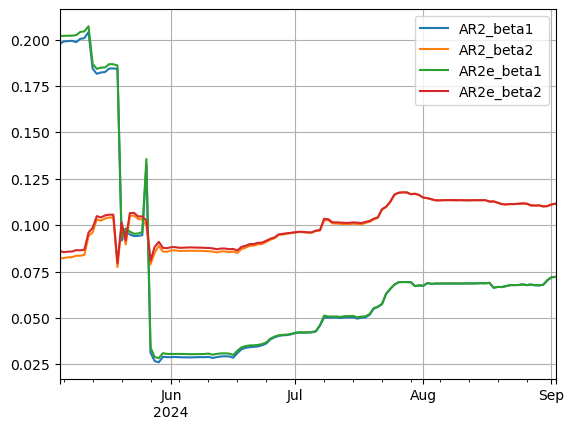

In [143]:
AR_betas[['AR2_beta1','AR2_beta2','AR2e_beta1','AR2e_beta2']].plot()
plt.grid()
plt.show()

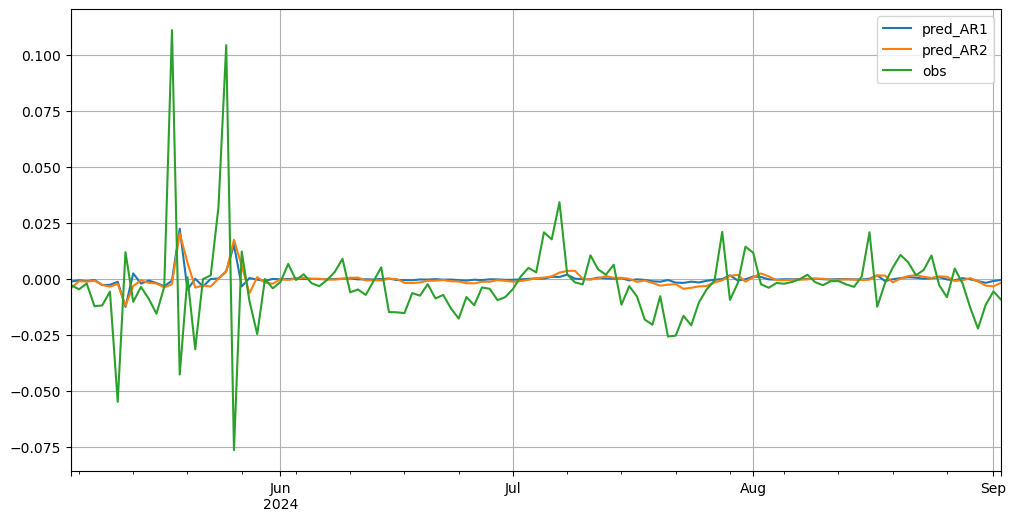

In [147]:
predictions.plot(figsize=(12,6))
plt.grid()
plt.show()

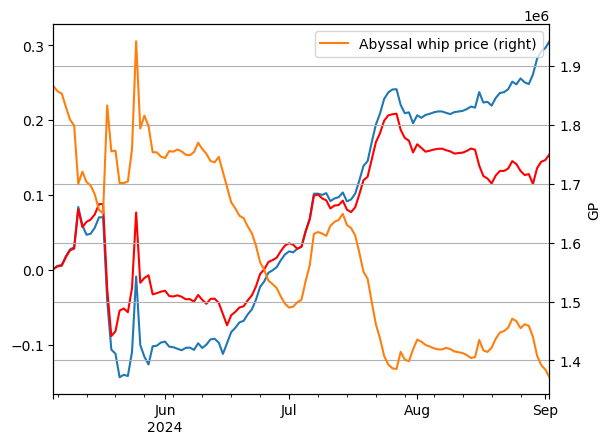

In [218]:
# Basic PnL in % returns for buy when signal is positive, sell when signal is negative, no filtering
# Assumes you place a trade every day

preds = predictions
preds = preds.join(df_whip[['avgWPrice']],how='left')

ax1 = ((preds['pred_AR1']*preds['obs']>0)*abs(preds['pred_AR1'] - preds['obs'])-
 (preds['pred_AR1']*preds['obs']<0)*abs(preds['pred_AR1']-preds['obs'])).cumsum().plot(label='AR1 PnL')

ax2 = ((preds['pred_AR2']*preds['obs']>0)*abs(preds['pred_AR2'] - preds['obs'])-
 (preds['pred_AR2']*preds['obs']<0)*abs(preds['pred_AR2']-preds['obs'])).cumsum().plot(label='AR2 PnL',color='red')

ax = preds['avgWPrice'].plot(secondary_y = True,label='Abyssal whip price')

ax.set_ylabel('GP')

plt.legend()
plt.grid()
plt.show()

In [145]:
'''
TODO:
    - Assume can only sell whip when you own one
    - Max inventory of one whip?
'''



'\nTODO:\n    - Assume can only sell whip when you own one\n    - Max inventory of one whip?\n'